In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..") # Adds the module to path

{{ badge }}

# Example 6. Cell Counting

Trains a U-Net to count the number of cells in the BBBC039 dataset.

## 1. Setup

Imports and defines the objects needed for this example.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
import skimage
import skimage.morphology
import scipy

import deeptrack as dt
import datasets
datasets.load("CellCounting")

IMAGE_SIZE = 256

../..\deeptrack\backend\_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
../..\deeptrack\backend\_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")


CellCounting already downloaded! Use force_overwrite=True to redownload the dataset.


## 2. Defining the dataset

We begin by defining a fluorescence microscope.

In [3]:
optics = dt.Fluorescence(
    resolution=1e-6,
    magnification=6,
    wavelength=400e-9,
    NA=lambda: 0.9 + np.random.rand() * 0.2,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)


### 2.1 Generating cell-like scatterers.

Cells are represented as random ellipses with some elastic transformation applied to them. We use the dummy properties `area` amd `ratio` to constrain the possible ellipses.

In [4]:
ellipse = dt.Ellipsoid(
    area=lambda: (np.random.rand() * 3e-6 + 1e-6) ** 2,
    ratio=lambda: 1 + np.random.rand() * 0.5,
    radius=lambda area, ratio: (np.sqrt(area) * ratio, np.sqrt(area) / ratio, np.sqrt(area) * (0.2 + np.random.rand() * 0.2)),
    position_unit="pixel",
    intensity=lambda: 0.5 + np.random.rand(),
    position=lambda: 20 + np.random.rand(2) * (IMAGE_SIZE - 40),
    rotation=lambda: np.random.rand() * 2 * np.pi,
    voxel_size=optics.voxel_size
)

ellipses = ellipse ^ (lambda: np.random.randint(1, 20))

# Padding to ensure that the elastic transformation has space to grow into
padded_ellipses = ellipses >> dt.Pad(px=(10, 10, 10, 10), keep_size=False)

# alpha and sigma chosen by observation.
cells = padded_ellipses >> dt.ElasticTransformation(alpha=100, sigma=10, keep_size=False)

Adding internal structure to the cells. We use poisson distributed noise and a 3d average smoothing filter.

In [5]:

noisy_cells = cells >> dt.Poisson(snr=lambda: 1.5 + np.random.rand() * 1.5)

kernel = np.ones((3, 3, 3)) / 27

smoothing = dt.Lambda(lambda: lambda image: scipy.ndimage.filters.convolve(image, kernel) * (image > 0)) 

# We apply the smoothening filter a random number of times to 
noisy_cells >>= smoothing ^ (lambda: np.random.randint(0, 3))

For each cell in the input, we calculate the centroid, and place a 1 at the nearest pixel.

In [6]:
def get_mask(image):
    projected_image = np.sum(image, axis=-1)
    mask = projected_image > 0.5
    X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    area = np.sum(mask)
    x_center = np.sum(mask * Y) / area
    y_center = np.sum(mask * X) / area
    output = np.zeros_like(image)
    output[int(x_center), int(y_center)] = 1
    return output

synthetic_mask = cells >> dt.SampleToMasks(
    lambda: get_mask, 
    number_of_masks=1,
    output_region=optics.output_region, 
    merge_method="add"
)

The synthetic mask created this way is convolved with a gaussian filter. This way we represent each cell by a gaussian curve.

In [7]:
from skimage.filters import gaussian 

NORM_FACTOR = 1000

def gaussian_filter(width):
    def apply_guassian_filter(image):
        image = np.pad(image, [(1, 1), (1, 1), (0, 0)])
        image = gaussian(image, width, truncate=2.5) * NORM_FACTOR
        image = image[1:-1, 1:-1]
        return image
    return apply_guassian_filter

make_gaussian = dt.Lambda(function=gaussian_filter, width=12)

blurred_synthetic_mask = synthetic_mask >> make_gaussian

Image the cells through an optical device. We also add some noise to the image, followed by normalizing it and augmenting it and the blurred masks together.

In [8]:

imaged_cells = optics(noisy_cells)

image_noise = dt.Gaussian(mu=lambda: np.random.rand() + 0.5, sigma=0.04)
saturation = dt.Clip(0, lambda: 17)
normalization = dt.NormalizeMinMax(min=lambda: np.random.rand() * 0.3, max=lambda min: min + 0.2 + np.random.rand() * (1 - min - 0.2))

noisy_image = imaged_cells >> image_noise >> saturation >> normalization

synthetic_dataset = dt.Reuse(noisy_image & blurred_synthetic_mask, 8) >> dt.FlipUD() >> dt.FlipLR() >> dt.FlipDiagonal()

### 2.3 Defining the validation set

We grab the filenames of the data in the different sets. Training and validation are merged into validation, since we don't use the training set.

In [9]:
DATASET_PATH = "./datasets/CellCounting/"
TRAINING_PATH = os.path.join(DATASET_PATH, "metadata", "validation.txt")
VALIDATION_PATH = os.path.join(DATASET_PATH, "metadata", "training.txt")
TEST_PATH = os.path.join(DATASET_PATH, "metadata", "test.txt")

training_filenames = open(TRAINING_PATH, "r").read().split("\n")[:-1]
validation_filenames = open(VALIDATION_PATH, "r").read().split("\n")[:-1]
test_filenames = open(TEST_PATH, "r").read().split("\n")[:-1]

validation_paths = [filename[:-4] for filename in training_filenames + validation_filenames]
test_paths = [filename[:-4] for filename in test_filenames]

We define image loading features for the validation images and masks. Here, `filename` is a dummy property. Note that `validation_image` has the filename set to `validation_filename_iterator`, while `validation_mask` has filename pointing to `validation_image.filename`. This way we ensure that they are grabbing a correct pair of images.

In [10]:
validation_filename_iterator = itertools.cycle(validation_paths)

validation_image = dt.LoadImage(
    filename=validation_filename_iterator,
    path=lambda filename: os.path.join(DATASET_PATH, "images", filename) + ".tif"
)

validation_mask = dt.LoadImage(
    filename=validation_image.filename,
    path=lambda filename: os.path.join(DATASET_PATH, "masks", filename) + ".png"
)

We do the same for the test set.

In [11]:
test_filename_iterator = itertools.cycle(test_paths)

test_image = dt.LoadImage(
    filename=test_filename_iterator,
    path=lambda filename: os.path.join(DATASET_PATH, "images", filename) + ".tif"
)

test_mask = dt.LoadImage(
    filename=test_image.filename,
    path=lambda filename: os.path.join(DATASET_PATH, "masks", filename) + ".png"
)

The masks are provided as color coded images. We define a feature that converts this to the masks used in training.

In [12]:
def decode_mask(validation_mask):
    integer_labels = skimage.morphology.label(validation_mask)[:, :, 0:1]
    props = skimage.measure.regionprops(integer_labels)

    output = np.zeros(integer_labels.shape)    
    for prop in props:
        centroid = prop["Centroid"]
        output[int(centroid[0]), int(centroid[1]), 0] = 1
    
    return output

png_to_mask = dt.Lambda(lambda: decode_mask) >> make_gaussian

In [18]:
normalization = dt.NormalizeMinMax()

blurred_validation_mask = validation_mask >> png_to_mask 
normalized_validation_image = validation_image >> normalization
validation_dataset = normalized_validation_image & blurred_validation_mask 

blurred_test_mask = test_mask >> png_to_mask
normalized_test_image = test_image >> normalization
test_dataset = normalized_test_image & blurred_test_mask

We also make sure they're a multiple of 16, which is needed by the network architecture.

In [19]:
cropper = dt.CropToMultiplesOf(16)

validation_dataset >>= cropper
test_dataset >>= cropper

We define a feature for loading the mask.

In [20]:
# Load labels from storage
def get_image(image):
    I = image[0]
    if I.ndim == 2:
        I = np.expand_dims(I, axis=-1)
    return I

def get_label(image):
    I = image[1]
    return I

### 2.4 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images and print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`.

../..\deeptrack\optics.py:221: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(1 - (NA / refractive_index_medium) ** 2 * RHO),


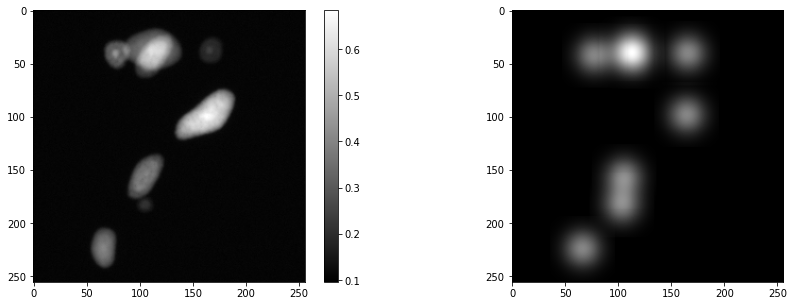

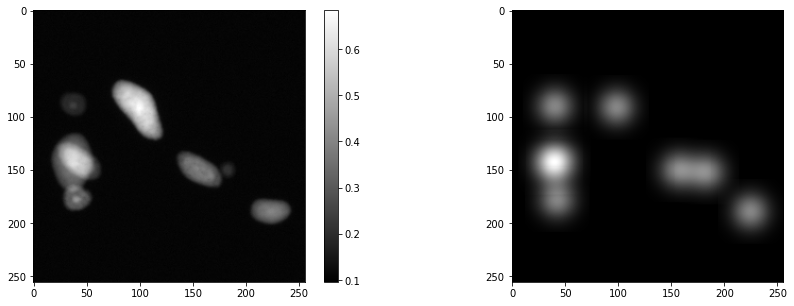

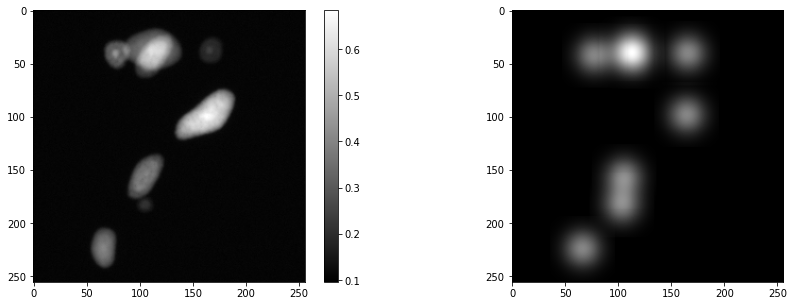

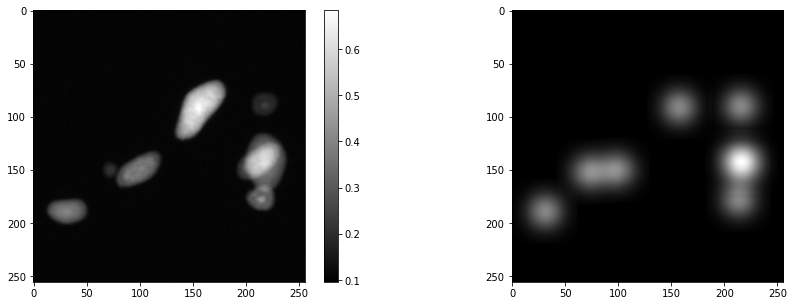

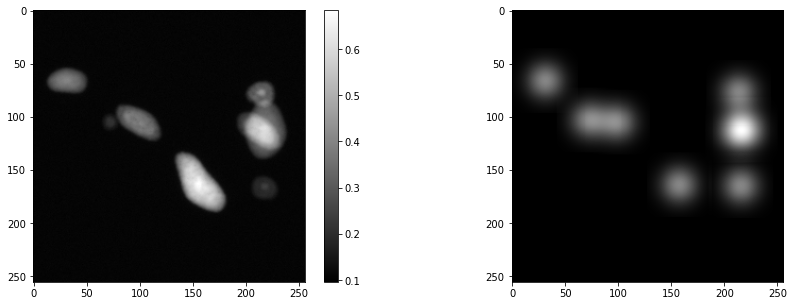

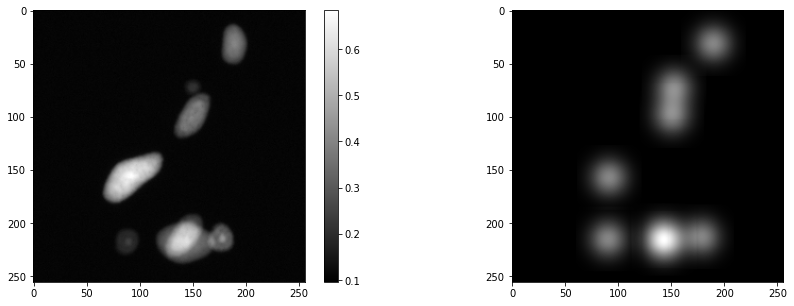

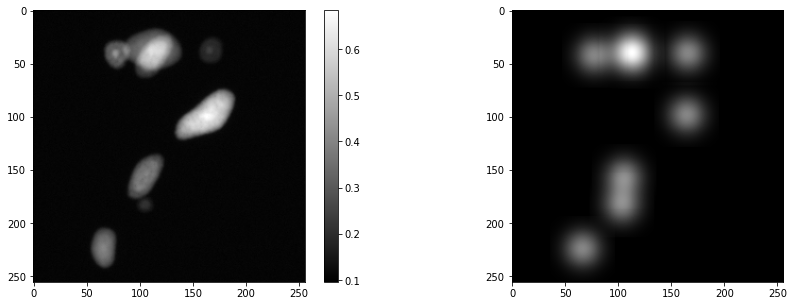

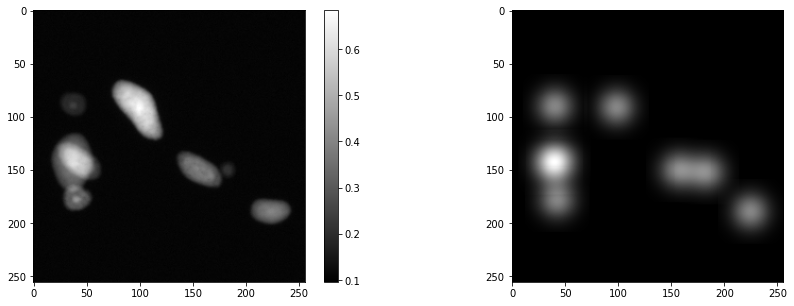

In [21]:
training_data = []
training_masks = []
for i in range(8):
        
    image, mask = synthetic_dataset.update().resolve()
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(mask[:, :, 0], cmap="gray")
    plt.show()

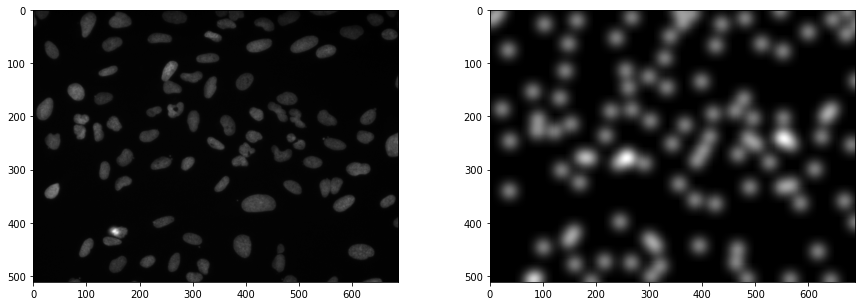

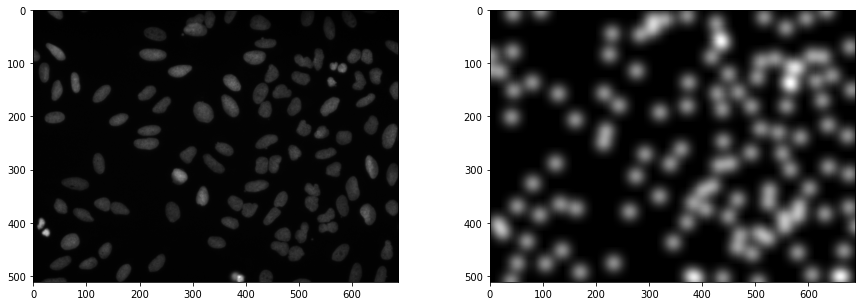

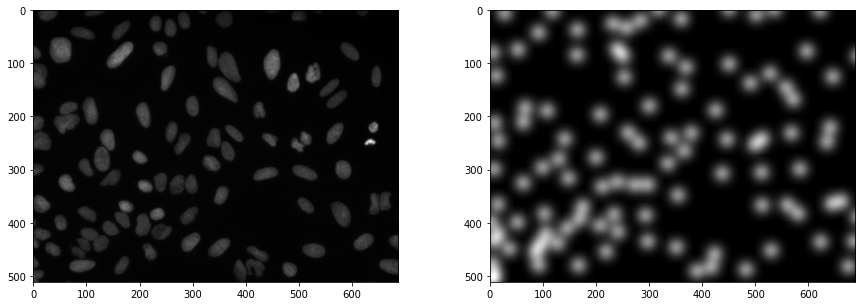

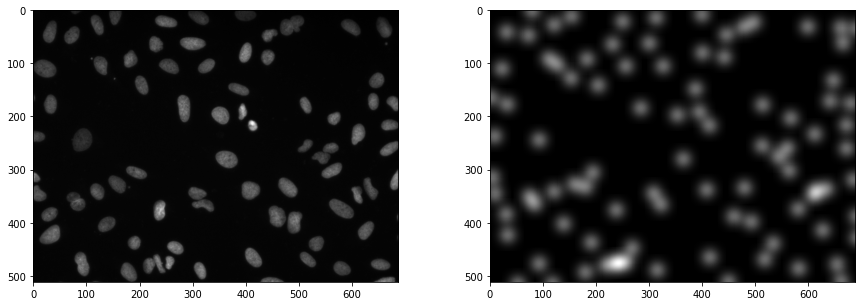

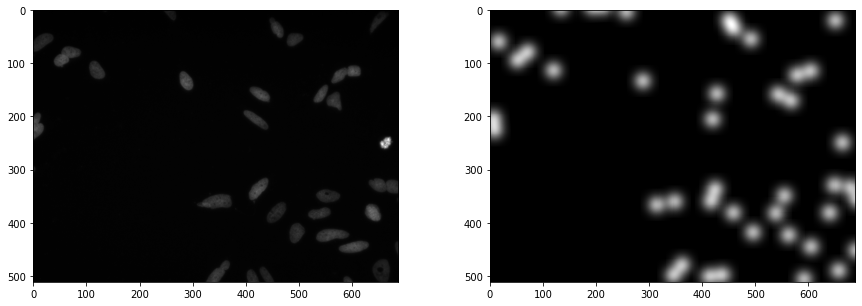

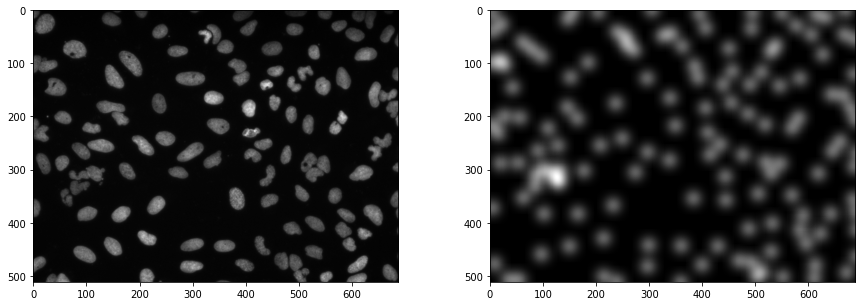

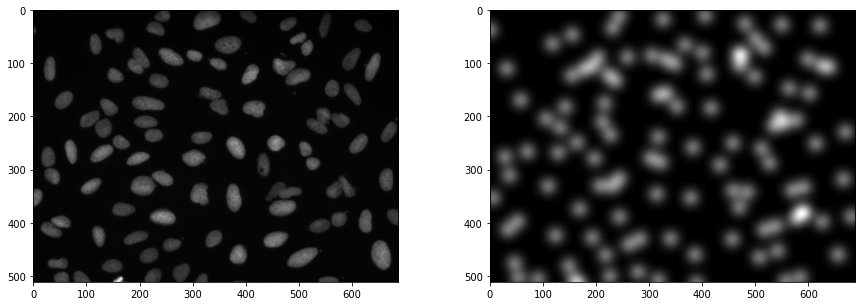

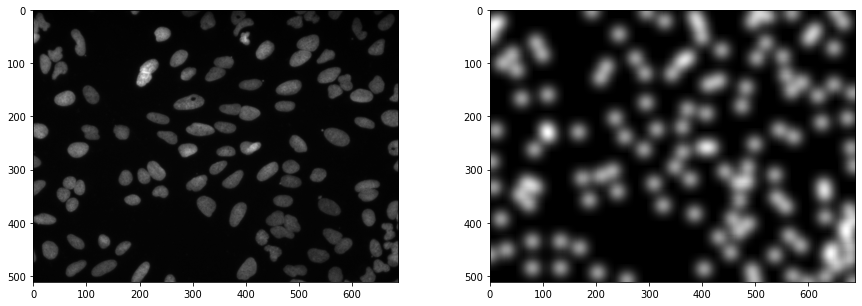

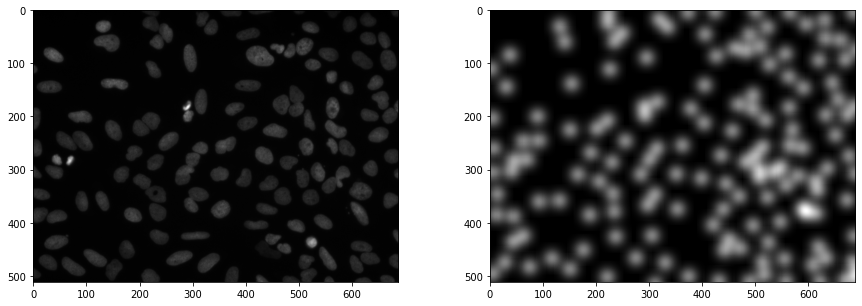

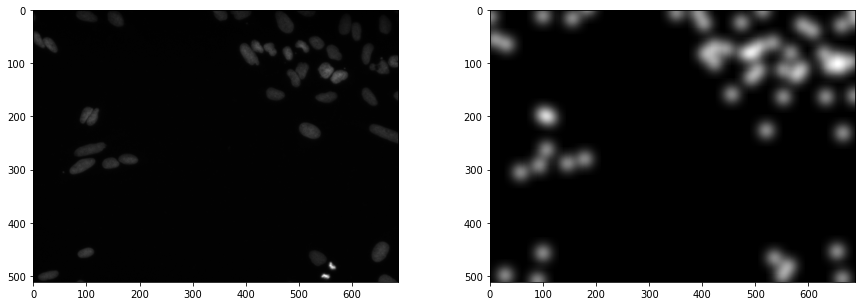

In [22]:
for _ in range(10):
    validation_dataset.update()
    image, mask = validation_dataset.resolve()
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(image, cmap="gray")
    plt.subplot(122)
    plt.imshow(mask[:, :, 0], cmap="gray")
    plt.show()

## 3. Defining the network

The network used is a U-Net Here we define the network architecture, loss function and the optimizer.

In [24]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.losses as losses
eps = 1e-6

loss_weights = [4, 1]

# Standard MAE
def mae(T, P):
    return K.mean(K.abs(T - P)) 

# Difference in mean
def count_error(T, P):
    return K.mean(K.abs(K.mean(T - P, axis=(1, 2)))) 

# Weighted sum of loss
def total_loss(T, P):
    return mae(T, P) * loss_weights[0] + count_error(T, P) * loss_weights[1]


model = dt.models.UNet(
    input_shape=(None, None, 1),
    number_of_outputs=1,
    steps_per_pooling=2,
    output_activation="relu",
    loss=total_loss,
    optimizer=tf.keras.optimizers.Adam(lr=0.0002, amsgrad=True, beta_1=0.5),
    metrics=[mae, count_error],
)
    
model.summary()

C:\Users\GU\.virtualenvs\AutoTrackingPaper-UvNsjtmo\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 1 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 2320        activation[0][0]                 
______________________________________________________________________________________________

## 4. Training the network

In [27]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    from tensorflow.keras.callbacks import EarlyStopping


    generator = dt.generators.ContinuousGenerator(
        synthetic_dataset, 
        get_label, 
        get_image, 
        batch_size=16, 
        min_data_size=1000, 
        max_data_size=1001,
    )

    validation_set = [validation_dataset.update().resolve() for _ in range(len(validation_paths))]
    validation_data = [get_image(v_tuple) for v_tuple in validation_set]
    validation_labels = [get_label(v_tuple) for v_tuple in validation_set]

    with generator:
        h = model.fit(
            generator,
            steps_per_epoch=8,
            epochs=500,
            workers=0,
            validation_data=(
                np.array(validation_data),
                np.array(validation_labels)
            ), 
            callbacks = [
                EarlyStopping("val_count_error", patience=50, restore_best_weights=True)
            ] 
        )
else:
    path = datasets.load_model("CellCounting")
    model.load_weights(path)

../..\deeptrack\optics.py:221: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(1 - (NA / refractive_index_medium) ** 2 * RHO),


Generating 1000 / 1000 samples before starting training
Epoch 1/500
8/8 [==============================] - 6s 490ms/step - loss: 0.4795 - mae: 0.0995 - count_error: 0.0816 - val_loss: 0.4969 - val_mae: 0.1062 - val_count_error: 0.0671
Epoch 2/500
8/8 [==============================] - 1s 150ms/step - loss: 0.2230 - mae: 0.0495 - count_error: 0.0249 - val_loss: 0.4485 - val_mae: 0.0958 - val_count_error: 0.0610
Epoch 3/500
8/8 [==============================] - 1s 142ms/step - loss: 0.1835 - mae: 0.0408 - count_error: 0.0201 - val_loss: 0.4173 - val_mae: 0.0982 - val_count_error: 0.0200
Epoch 4/500
8/8 [==============================] - 1s 146ms/step - loss: 0.1878 - mae: 0.0414 - count_error: 0.0220 - val_loss: 0.4082 - val_mae: 0.0947 - val_count_error: 0.0259
Epoch 5/500
8/8 [==============================] - 1s 146ms/step - loss: 0.2230 - mae: 0.0493 - count_error: 0.0257 - val_loss: 0.6308 - val_mae: 0.1388 - val_count_error: 0.0693
Epoch 6/500
8/8 [==============================] 

## 5. Evaluating the training

### 5.1 Prediction vs actual

We show a few images and predicted number of cells

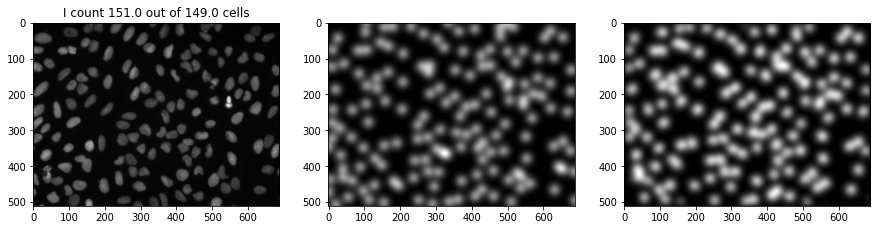

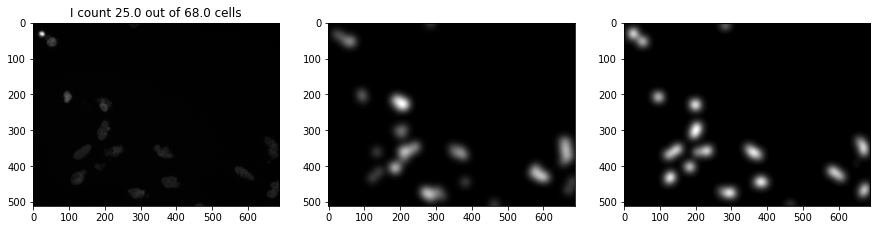

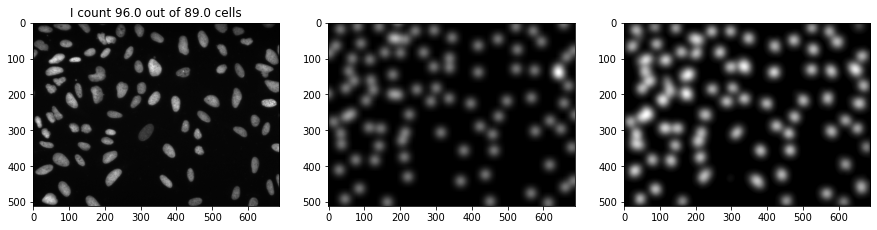

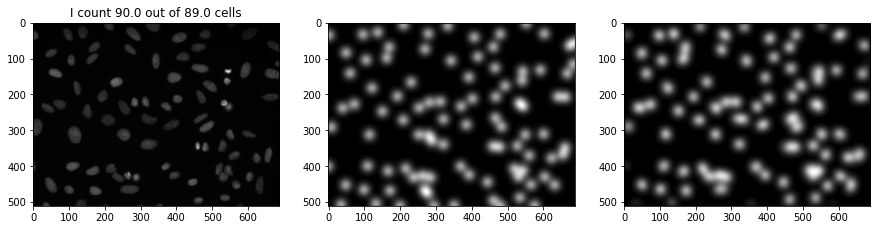

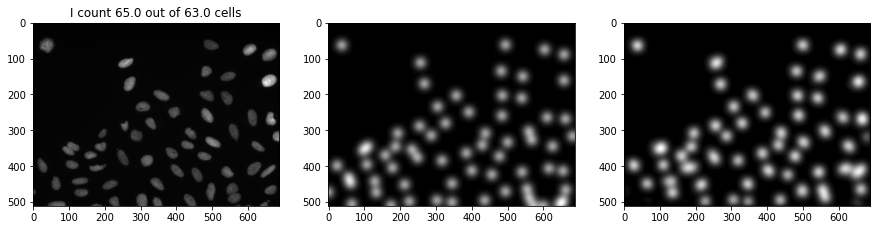

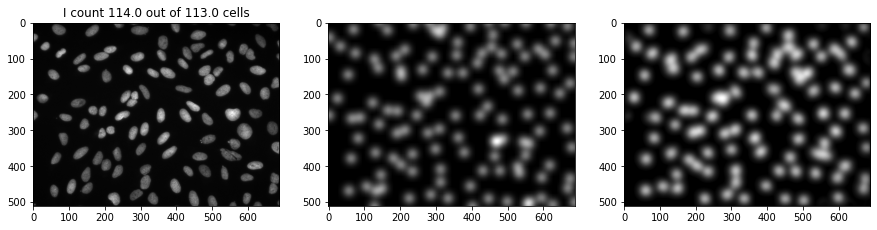

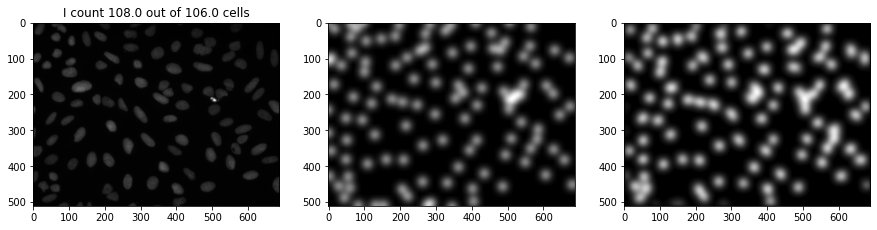

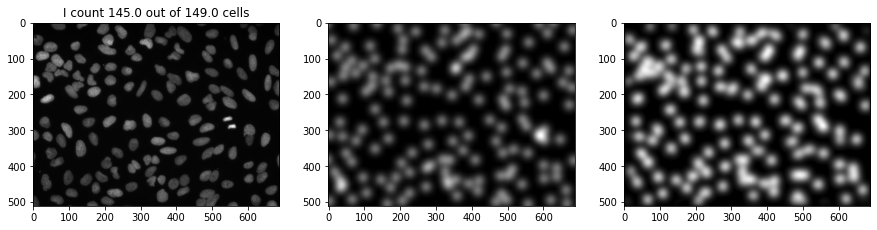

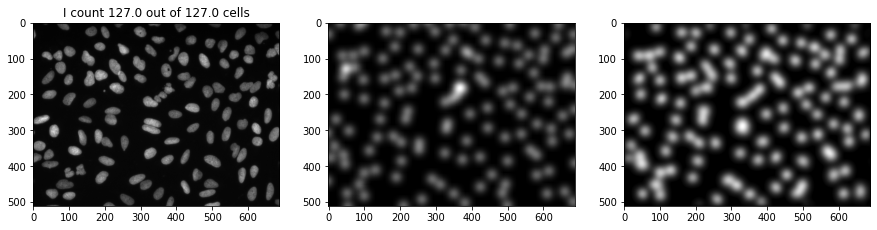

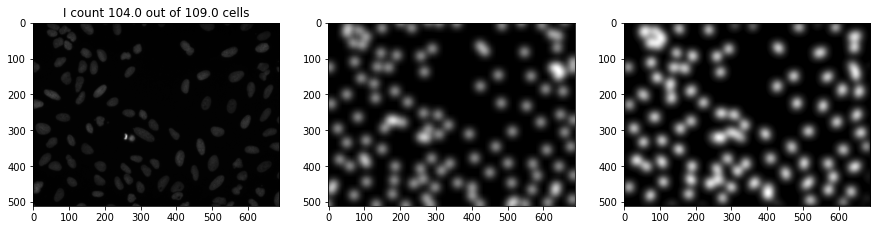

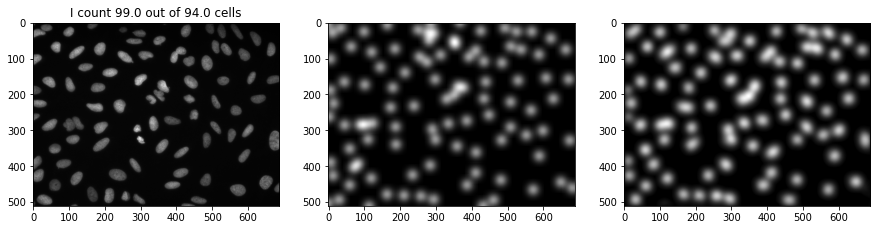

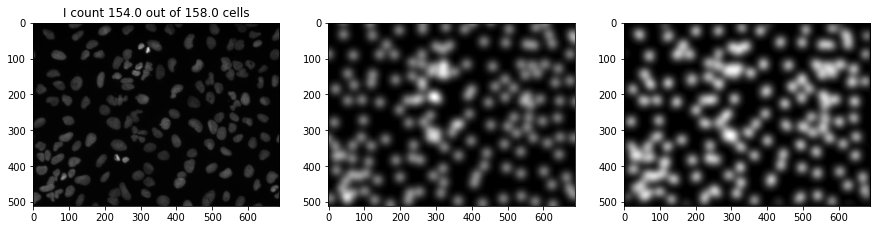

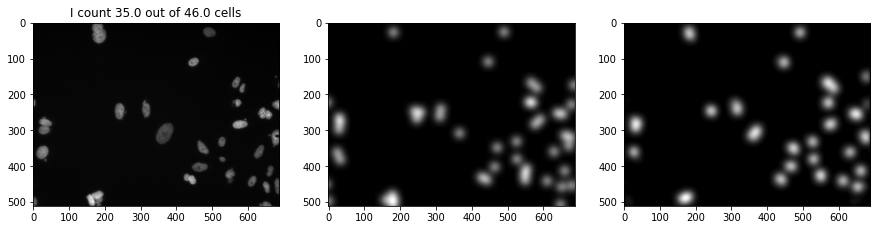

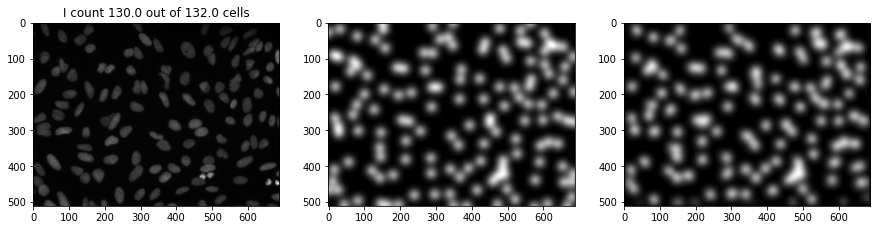

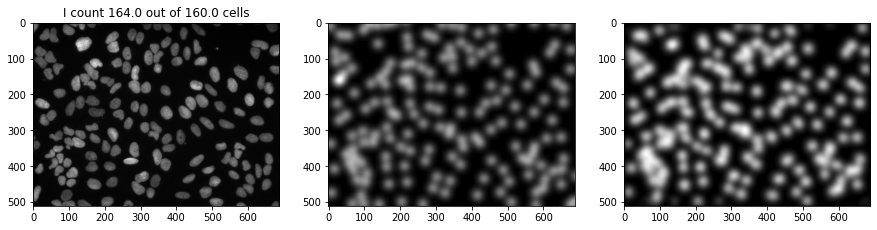

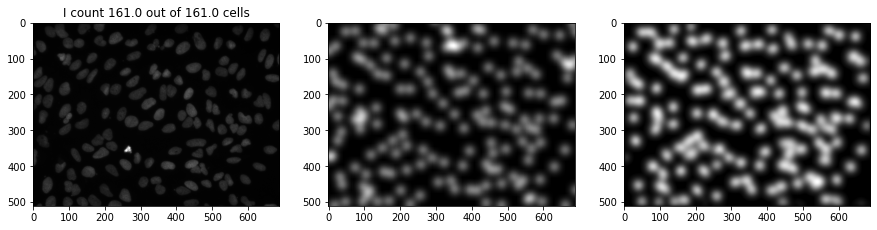

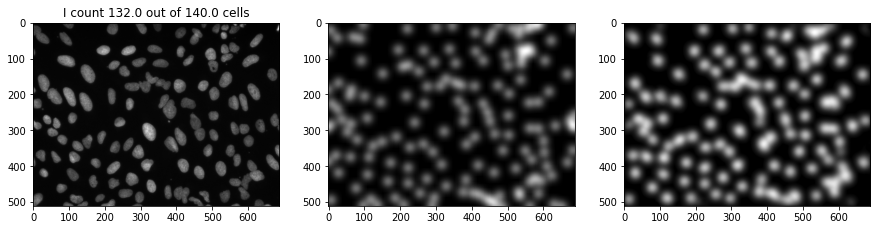

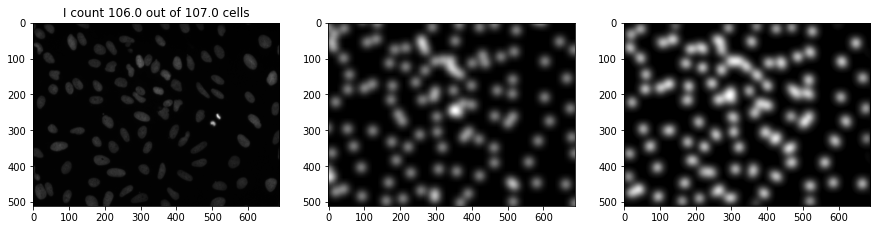

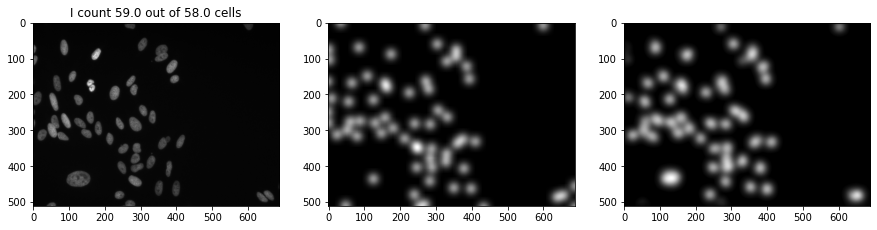

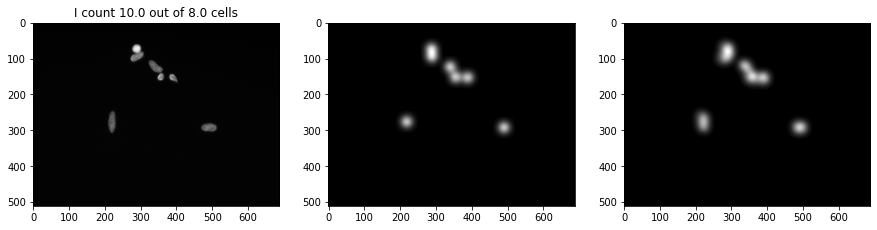

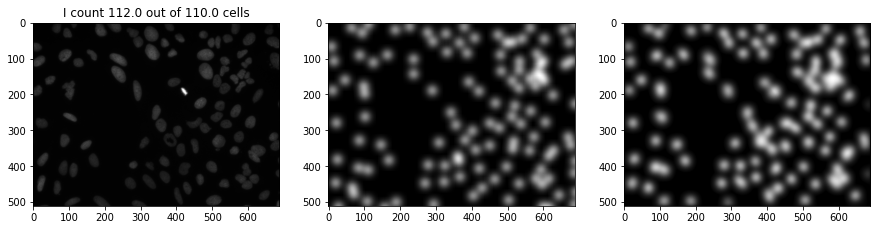

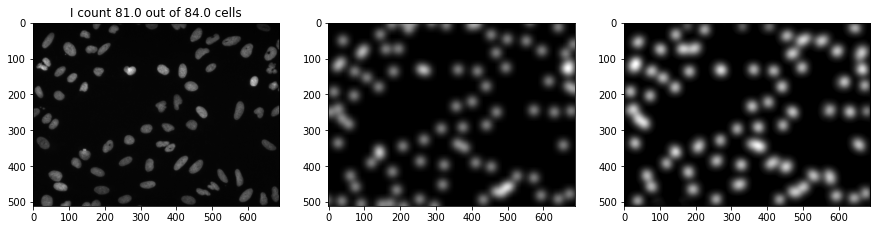

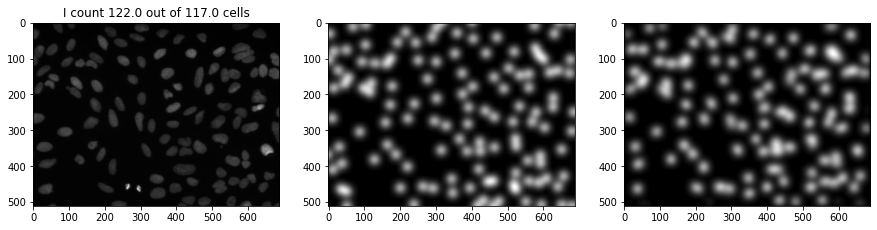

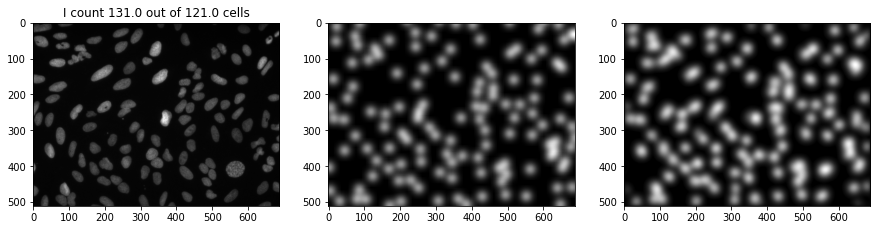

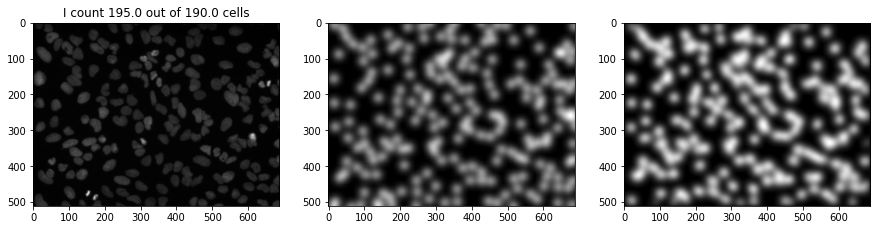

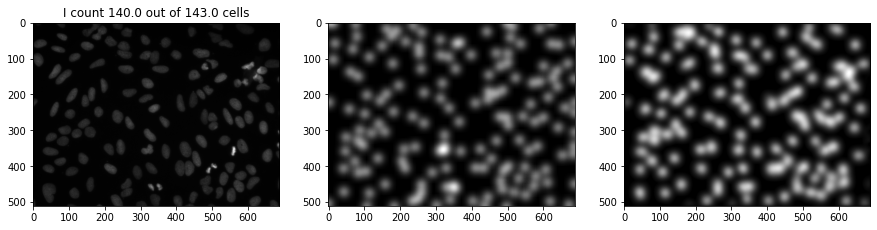

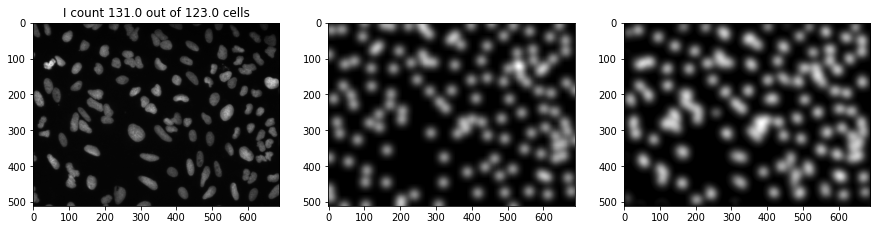

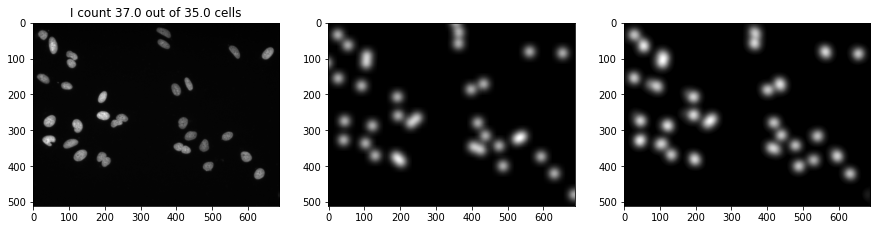

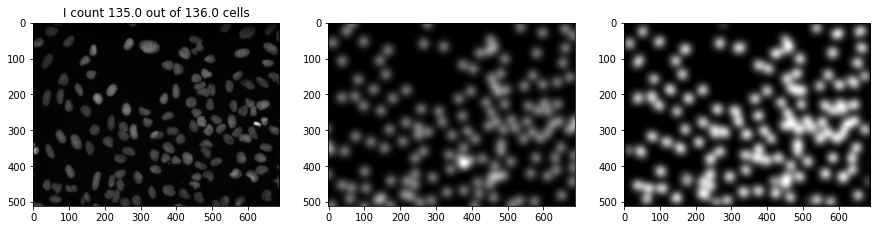

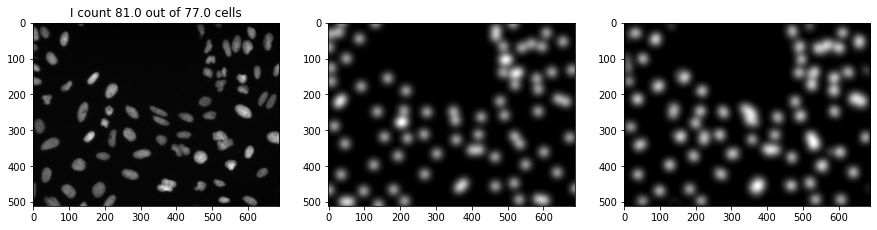

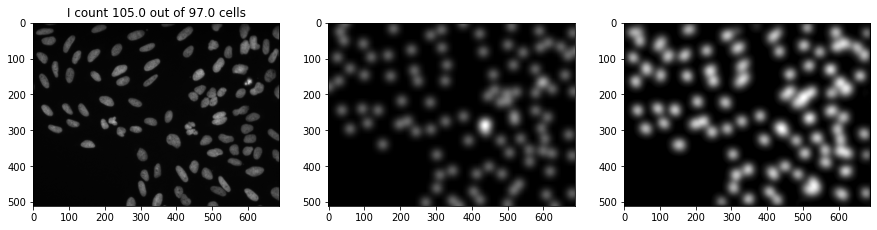

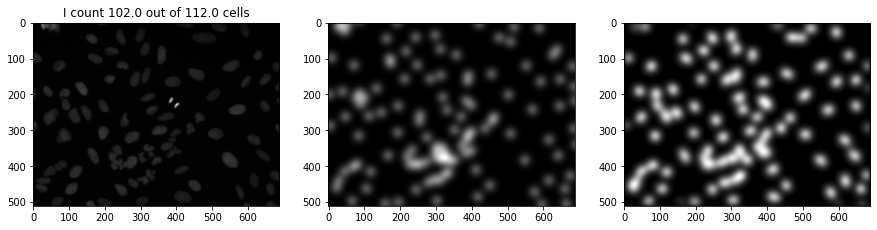

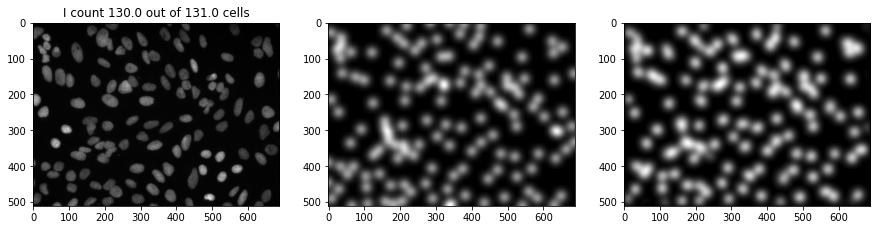

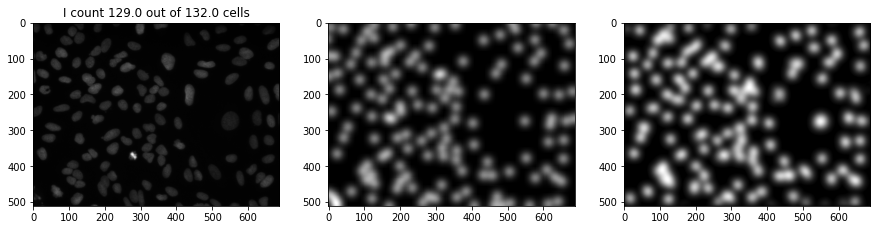

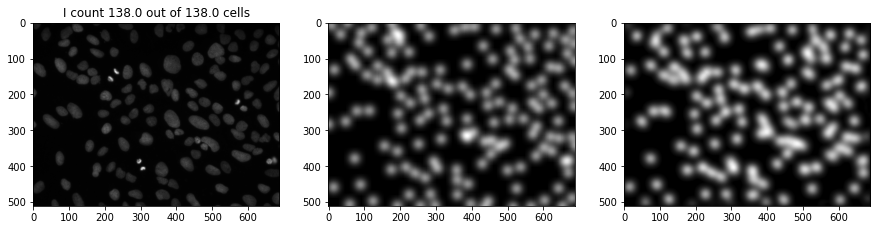

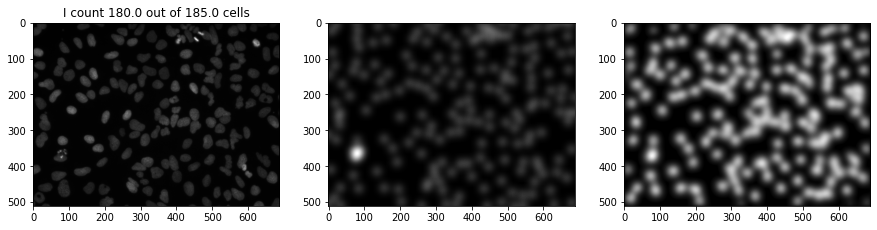

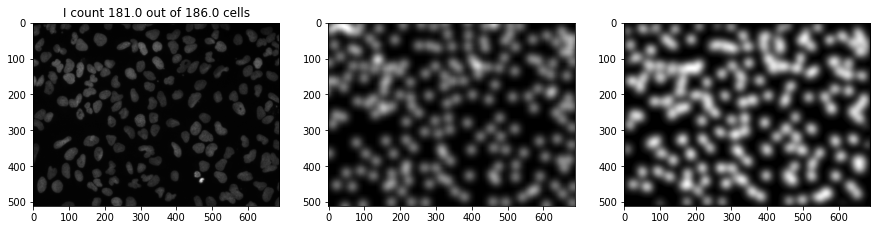

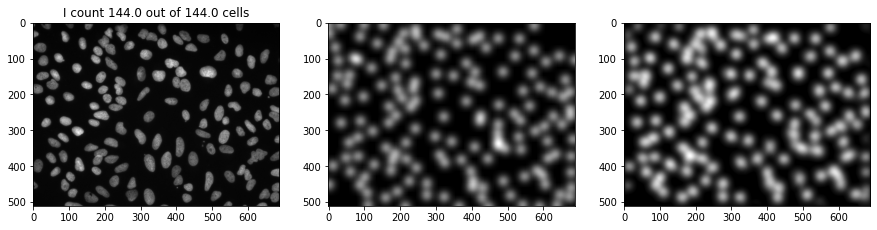

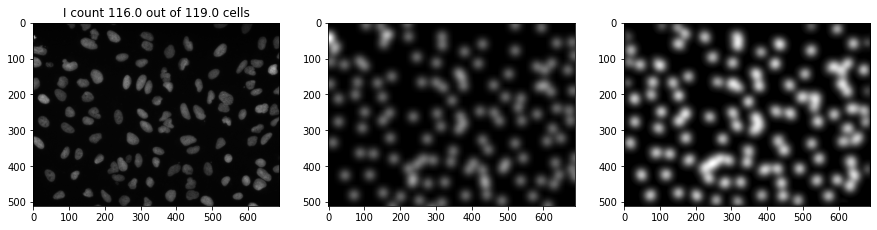

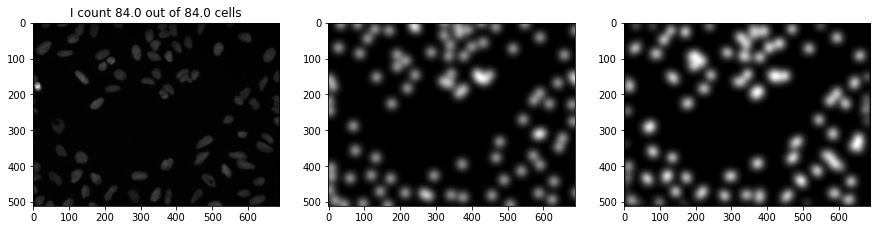

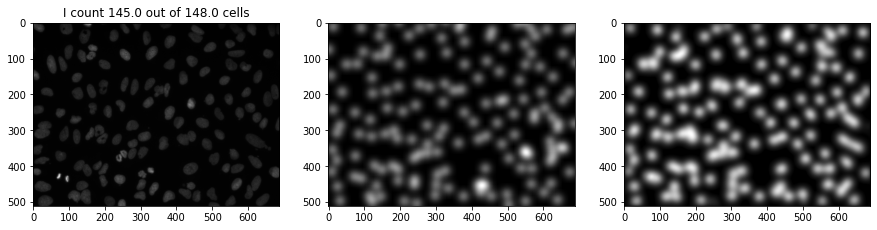

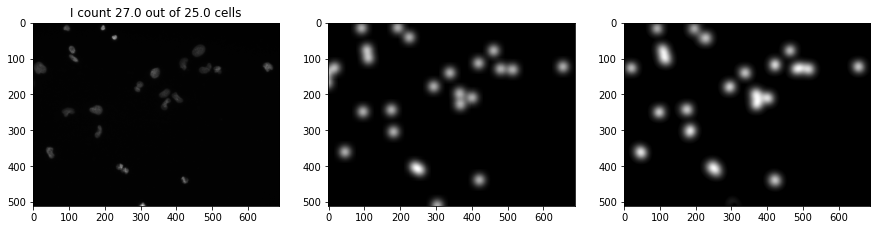

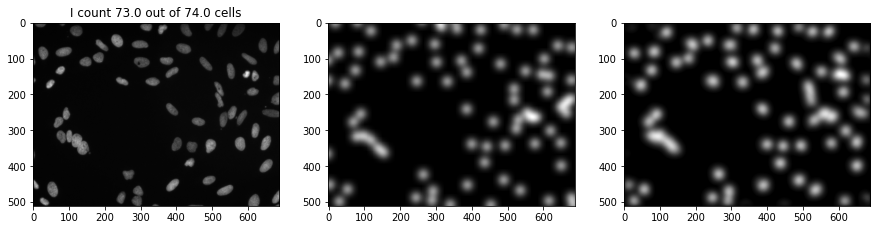

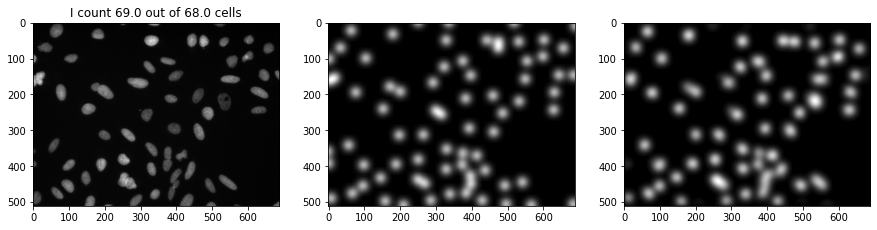

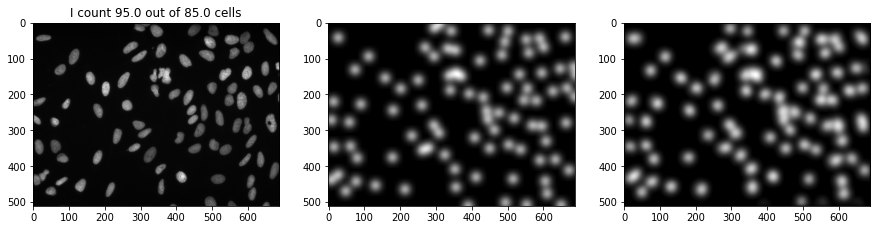

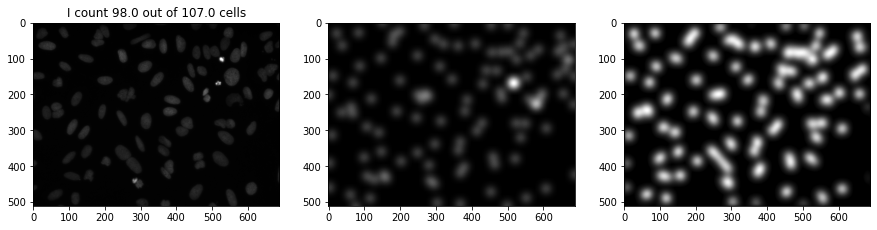

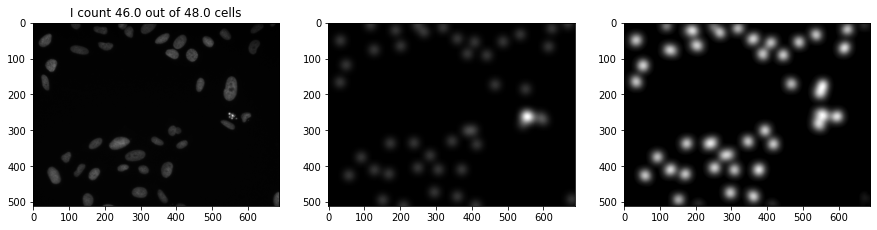

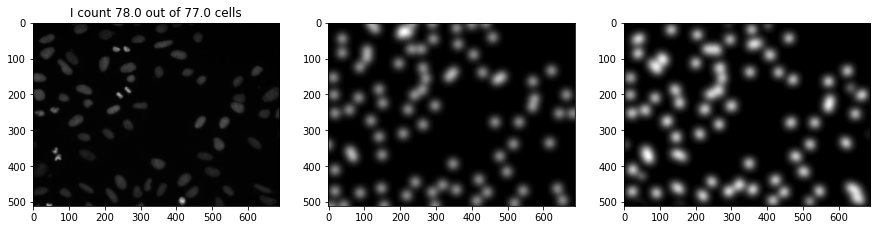

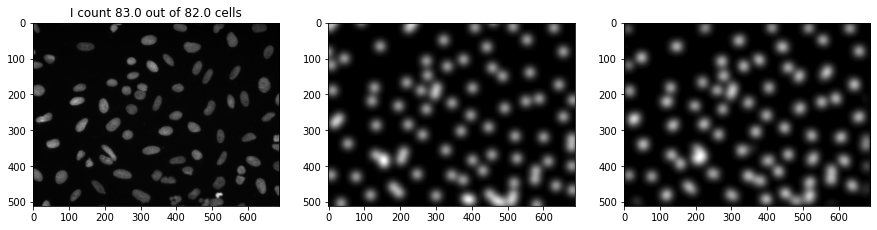

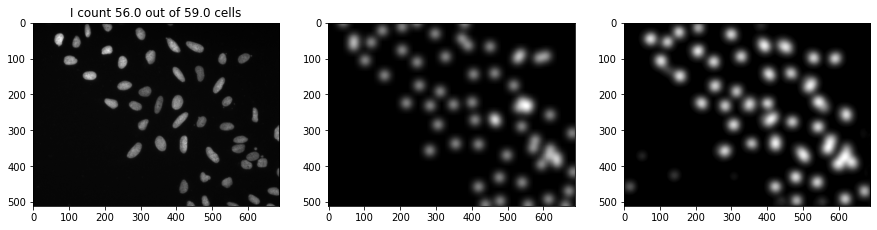

In [28]:
test_set = [test_dataset.update().resolve() for _ in range(len(test_paths))]
test_data = [get_image(v_tuple) for v_tuple in test_set]
test_labels = [get_label(v_tuple) for v_tuple in test_set]

predictions = model.predict(np.array(test_data))
for image, mask, prediction in zip(test_data, test_labels, predictions):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(image[:, :, 0], cmap="gray")
    plt.title("I count {0} out of {1} cells".format(
        np.ceil(np.sum(prediction[:, :, 0]) / NORM_FACTOR),
        np.ceil(np.sum(mask[:, :, 0]) / NORM_FACTOR)
    ))
    
    plt.subplot(132)
    plt.imshow(mask[:, :, 0], cmap="gray")
    
    plt.subplot(133)
    plt.imshow(prediction[:, :, 0], cmap="gray")
    plt.show()
